/var/folders/64/xz573gks0_g0yncbndhjq6fm0000gn/T/ipykernel_69045/3798872441.py:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(log_ret.mean())
/var/folders/64/xz573gks0_g0yncbndhjq6fm0000gn/T/ipykernel_69045/3798872441.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(log_ret.std(ddof=1))
/var/folders/64/xz573gks0_g0yncbndhjq6fm0000gn/T/ipykernel_69045/3798872441.py:185: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  s0 = float(prices.iloc[-1])



--- Monte Carlo Risk Metrics ---
S0: 682.390015
Expected_Terminal: 778.638981
Median_Terminal: 763.428796
Std_Terminal: 152.980613
Expected_Terminal_Return: 0.141047
Prob_Loss: 0.280200
Prob_Drawdown_Breach: 0.265500
VaR_5%: -0.186619
VaR_1%: -0.276809


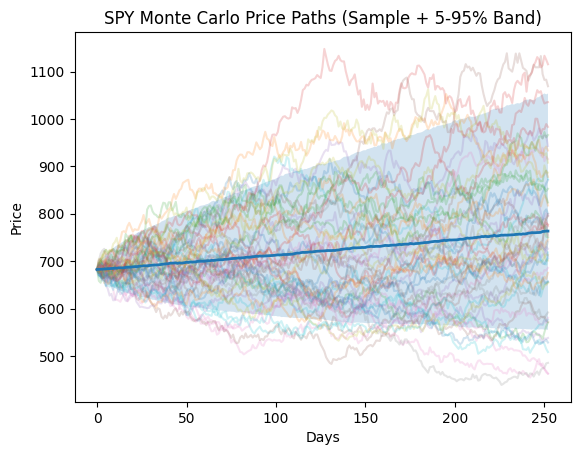

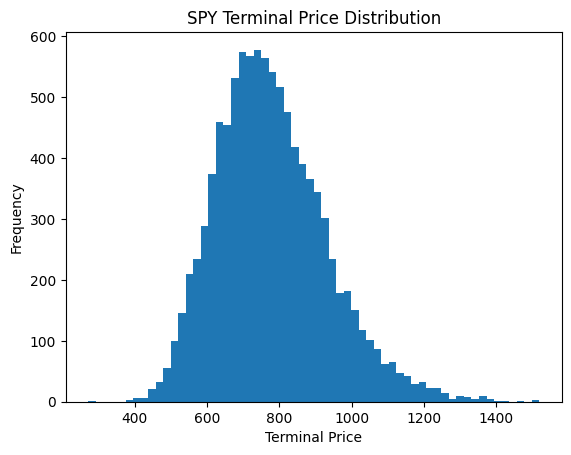

In [2]:
"""
Monte Carlo Simulation for Financial Risk Modeling
--------------------------------------------------
What this does:
- Downloads historical prices (yfinance)
- Estimates drift & volatility from log returns
- Simulates thousands of future price paths (GBM)
- Computes risk metrics: expected terminal value, VaR-style thresholds,
  probability of loss, probability of breaching a drawdown level
- Visualizes price paths + terminal distribution + confidence interval band

Typical quant points:
- Uses log returns (additive through time)
- Annualization with 252 trading days
- Vectorized simulation (no Python loops over paths)
"""

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import yfinance as yf
except ImportError:
    raise ImportError("Please install yfinance: pip install yfinance")


TRADING_DAYS = 252


def download_adj_close(ticker: str, start: str = "2018-01-01") -> pd.Series:
    """
    Download adjusted close prices and return a clean Series.
    """
    df = yf.download(ticker, start=start, auto_adjust=True, progress=False)
    if df.empty:
        raise ValueError(f"No data returned for ticker={ticker}. Check ticker or internet.")
    prices = df["Close"].dropna()
    prices.name = ticker
    return prices


def estimate_gbm_params(prices: pd.Series) -> tuple[float, float]:
    """
    Estimate GBM parameters from daily log returns:
    - mu: mean daily log return
    - sigma: daily volatility of log returns
    """
    log_ret = np.log(prices / prices.shift(1)).dropna()
    mu = float(log_ret.mean())
    sigma = float(log_ret.std(ddof=1))
    return mu, sigma


def simulate_gbm_paths(
    s0: float,
    mu: float,
    sigma: float,
    days: int,
    n_sims: int,
    seed: int | None = 42
) -> np.ndarray:
    """
    Simulate GBM price paths using log returns:
      S_t = S_0 * exp( cumulative_sum( (mu - 0.5*sigma^2) + sigma*Z_t ) )

    Returns:
      paths: shape (n_sims, days+1)
    """
    rng = np.random.default_rng(seed)

    # shocks: Z ~ N(0,1)
    z = rng.standard_normal(size=(n_sims, days))

    # GBM daily log increment
    drift = (mu - 0.5 * sigma**2)
    increments = drift + sigma * z

    # cumulative log returns and convert to prices
    log_paths = np.cumsum(increments, axis=1)
    paths = s0 * np.exp(log_paths)

    # include initial value at t=0
    paths = np.concatenate([np.full((n_sims, 1), s0), paths], axis=1)
    return paths


def compute_risk_metrics(
    paths: np.ndarray,
    var_levels: tuple[float, ...] = (0.05, 0.01),
    loss_threshold: float = 0.0,
    drawdown_level: float = -0.20
) -> dict:
    """
    Compute terminal distribution metrics + tail risk probabilities.

    - VaR-style thresholds: quantiles of terminal return distribution
    - Probability of loss: P(terminal_return < loss_threshold)
    - Probability of drawdown breach: any time drawdown <= drawdown_level
    """
    s0 = paths[:, 0]
    terminal = paths[:, -1]
    terminal_ret = terminal / s0 - 1.0

    # VaR-style quantiles on terminal returns (e.g., 5% and 1%)
    var = {f"VaR_{int(p*100)}%": float(np.quantile(terminal_ret, p)) for p in var_levels}

    prob_loss = float(np.mean(terminal_ret < loss_threshold))

    # Drawdown per path: (price / rolling_max) - 1
    running_max = np.maximum.accumulate(paths, axis=1)
    drawdowns = paths / running_max - 1.0
    prob_dd_breach = float(np.mean(np.min(drawdowns, axis=1) <= drawdown_level))

    metrics = {
        "S0": float(s0[0]),
        "Expected_Terminal": float(np.mean(terminal)),
        "Median_Terminal": float(np.median(terminal)),
        "Std_Terminal": float(np.std(terminal, ddof=1)),
        "Expected_Terminal_Return": float(np.mean(terminal_ret)),
        "Prob_Loss": prob_loss,
        "Prob_Drawdown_Breach": prob_dd_breach,
        **var,
    }
    return metrics


def confidence_band(paths: np.ndarray, lower_q: float = 0.05, upper_q: float = 0.95) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Pointwise confidence band across time:
    - median path
    - lower quantile path
    - upper quantile path
    """
    median = np.quantile(paths, 0.50, axis=0)
    lower = np.quantile(paths, lower_q, axis=0)
    upper = np.quantile(paths, upper_q, axis=0)
    return median, lower, upper


def plot_results(paths: np.ndarray, ticker: str) -> None:
    """
    Visualize:
    - sample of price paths
    - confidence band
    - terminal distribution histogram
    """
    n_sims, t_len = paths.shape
    x = np.arange(t_len)

    # --- Plot sample paths + confidence band ---
    plt.figure()
    sample_n = min(50, n_sims)
    plt.plot(x, paths[:sample_n].T, alpha=0.20)
    med, lo, hi = confidence_band(paths, 0.05, 0.95)
    plt.plot(x, med, linewidth=2)
    plt.fill_between(x, lo, hi, alpha=0.20)
    plt.title(f"{ticker} Monte Carlo Price Paths (Sample + 5-95% Band)")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.show()

    # --- Plot terminal distribution ---
    terminal = paths[:, -1]
    plt.figure()
    plt.hist(terminal, bins=60)
    plt.title(f"{ticker} Terminal Price Distribution")
    plt.xlabel("Terminal Price")
    plt.ylabel("Frequency")
    plt.show()


def main():
    # --- User-configurable ---
    ticker = "SPY"
    start = "2018-01-01"
    horizon_days = 252
    n_sims = 10000

    prices = download_adj_close(ticker, start=start)
    mu, sigma = estimate_gbm_params(prices)

    s0 = float(prices.iloc[-1])
    paths = simulate_gbm_paths(s0=s0, mu=mu, sigma=sigma, days=horizon_days, n_sims=n_sims, seed=42)

    metrics = compute_risk_metrics(
        paths,
        var_levels=(0.05, 0.01),
        loss_threshold=0.0,      # probability of finishing below initial price
        drawdown_level=-0.20     # probability of ever hitting -20% drawdown
    )

    print("\n--- Monte Carlo Risk Metrics ---")
    for k, v in metrics.items():
        print(f"{k:}: {v:.6f}" if isinstance(v, float) else f"{k:}: {v}")

    plot_results(paths, ticker=ticker)


if __name__ == "__main__":
    main()